In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Conv2D,MaxPool2D,Activation,Dense,Flatten
from tensorflow.keras.models import Sequential

In [75]:
import zipfile
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip

#Unzip our data
zip_ref = zipfile.ZipFile("10_food_classes_all_data.zip","r")
zip_ref.extractall()
zip_ref.close()


--2025-05-22 07:53:47--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.207, 74.125.195.207, 172.253.117.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip.1’

10_food_classes_all 100%[===================>] 495.13M  76.5MB/s    in 7.1s    

2025-05-22 07:53:54 (69.3 MB/s) - ‘10_food_classes_all_data.zip.1’ saved [519183241/519183241]



In [76]:
# Setup train and test directories
train_dir = "10_food_classes_all_data/train/"
test_dir = "10_food_classes_all_data/test/"
# Lets get the class names
import pathlib
import numpy as np
data_dir = pathlib.Path(train_dir)
class_names = np.array(sorted([item.name for item in data_dir.glob("*")]))
class_names

array(['chicken_curry', 'chicken_wings', 'fried_rice', 'grilled_salmon',
       'hamburger', 'ice_cream', 'pizza', 'ramen', 'steak', 'sushi'],
      dtype='<U14')

In [77]:
#plot validation and training curves separately
import pandas as pd
def plot_loss_curves(history):
  df=pd.DataFrame(history.history)

  acc = df["accuracy"]
  val_acc = df["val_accuracy"]
  loss = df["loss"]
  val_loss = df["val_loss"]
  epochs = range(len(history.history["loss"]))
  plt.figure(figsize = (10,10))
  #ACCURACY
  plt.subplot(2,2,1)
  plt.plot(epochs,acc,label = "training_accuracy")
  plt.plot(epochs,val_acc,label = "validation_accuracy")
  plt.title("Accuracy")
  plt.legend()
  # LOSS
  plt.subplot(2,2,2)
  plt.plot(epochs,loss,label = "training_loss")
  plt.plot(epochs,val_loss,label = "validation_loss")
  plt.title("Loss")
  plt.legend()
  plt.show()
  return None

In [78]:
# Make a prediction using model
#Create a function to import a image and resize it to be able to be used with our model
def load_and_prep(filename,img_shape=224):
  """
  Reads an image from filename and reshapes it into a tensor of desired size(here 224)
  (img_shape,img_shape,color_channels)
  """
  # READ IN THE IMAGE
  img = tf.io.read_file(filename)
  # DECODE THE READ FILE INTO A TENSOR
  img = tf.image.decode_image(img)
  # RESIZE THE IMAGE
  img  = tf.image.resize(img,size = [img_shape,img_shape])
  # RESCALE THE IMAGE AND GET ALL VALUES BETWEEN 0 AND 1
  img = img/255.0
  return img

def pred_and_plot(model,filename,class_names = class_names):
  """
  IMPORTS IMAGE AND MAKES A PREDICTION ON IMAGE
  AND PLOTS IT WITH PREDICTED CLASS NAME
  """
  # IMPORT TARGET IMAGE AND PREPROCESS IT
  img = load_and_prep(filename)
  # MAKE A PREDICTION
  pred = model.predict(tf.expand_dims(img,axis = 0))[0]
  # GET PREDICTED CLASS

  pred_class = class_names[(tf.argmax(pred))]
  # PLOT THE IMAGE AND PREDICTED CLASS

  plt.imshow(img)
  plt.title(f"Predicted : {pred_class} ")
  plt.axis(False)
  plt.show()

In [79]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen_augmented = ImageDataGenerator(rescale = 1/255.,
                                          rotation_range =0.2,
                                          width_shift_range = 0.2,
                                          height_shift_range = 0.2,
                                          zoom_range = 0.2,
                                          horizontal_flip = True
                                          )
train_data_augmented = train_datagen_augmented.flow_from_directory(train_dir,
                                                                    target_size = (224,224),
                                                                    class_mode = "categorical",
                                                                    batch_size = 32)

test_datagen = ImageDataGenerator(rescale = 1./255.)
test_data = test_datagen.flow_from_directory(test_dir,
                                               target_size = (224,224),
                                               class_mode = "categorical",
                                               batch_size = 32)

Found 7500 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


In [80]:
#Set seed
tf.random.set_seed(42)
# Create a model
model_4 = Sequential([
    Conv2D(10,3,activation="relu",input_shape=(224,224,3)),
    Conv2D(10,3,activation="relu"),
    MaxPool2D(),
    Conv2D(10,3,activation="relu"),
    Conv2D(10,3,activation="relu"),
    MaxPool2D(),
    Flatten(),
    Dense(10,activation="softmax")
])

#Compile it
model_4.compile(loss = tf.keras.losses.CategoricalCrossentropy(),
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])



/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [81]:
# Setup EarlyStopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", # monitor validation accuracy
                                                  patience=3) # if val loss decreases for 3 epochs in a row, stop

# Fit the model with the EarlyStopping callback
history_4_early_stop = model_4.fit(train_data_augmented,
                                   epochs=13, # Set a large number of epochs, EarlyStopping will stop it early
                                   steps_per_epoch=len(train_data_augmented),
                                   validation_data=test_data,
                                   validation_steps=len(test_data),
                                   callbacks=[early_stopping])

Epoch 1/13
235/235 ━━━━━━━━━━━━━━━━━━━━ 103s 424ms/step - accuracy: 0.1624 - loss: 2.3016 - val_accuracy: 0.2872 - val_loss: 2.0230
Epoch 2/13
235/235 ━━━━━━━━━━━━━━━━━━━━ 99s 420ms/step - accuracy: 0.2558 - loss: 2.1110 - val_accuracy: 0.3088 - val_loss: 1.9633
Epoch 3/13
235/235 ━━━━━━━━━━━━━━━━━━━━ 141s 416ms/step - accuracy: 0.2860 - loss: 2.0511 - val_accuracy: 0.3068 - val_loss: 1.9688
Epoch 4/13
235/235 ━━━━━━━━━━━━━━━━━━━━ 98s 416ms/step - accuracy: 0.2976 - loss: 1.9942 - val_accuracy: 0.3744 - val_loss: 1.8454
Epoch 5/13
235/235 ━━━━━━━━━━━━━━━━━━━━ 97s 415ms/step - accuracy: 0.3154 - loss: 1.9598 - val_accuracy: 0.3496 - val_loss: 1.8376
Epoch 6/13
235/235 ━━━━━━━━━━━━━━━━━━━━ 97s 414ms/step - accuracy: 0.3382 - loss: 1.9297 - val_accuracy: 0.3964 - val_loss: 1.7883
Epoch 7/13
235/235 ━━━━━━━━━━━━━━━━━━━━ 142s 414ms/step - accuracy: 0.3405 - loss: 1.9006 - val_accuracy: 0.4056 - val_loss: 1.7945
Epoch 8/13
235/235 ━━━━━━━━━━━━━━━━━━━━ 98s 415ms/step - accuracy: 0.3532 - loss

In [100]:
# Access the history dictionary
history_dict = history_4_early_stop.history

# Get the training accuracy up to the interrupted epoch
training_accuracy = history_dict['accuracy'][:13]

# Get the validation accuracy up to the interrupted epoch
validation_accuracy = history_dict['val_accuracy'][:13]

# You can do the same for loss and val_loss
training_loss = history_dict['loss'][:13]
validation_loss = history_dict['val_loss'][:13]

print("Training Accuracy:",np.mean(training_accuracy))
print("Validation Accuracy:", np.mean(validation_accuracy))
print("Training Loss:", np.mean(training_loss))
print("Validation Loss:",np.mean( validation_loss))

Training Accuracy: 0.33178461629610795
Validation Accuracy: 0.38569230758226836
Training Loss: 1.9209107068868785
Validation Loss: 1.7972910771003137


In [83]:
# Convolution explained:
# Think of convolution as a magnifying glass that slides over an image.
# It focuses on small parts of the image at a time. This magnifying glass has a pattern
# (called a filter or kernel) that it's looking for. As it slides across the image,
# it checks how much of that pattern is present in the area it's currently looking at.
# The result of this check is a single number for that area. By doing this for the whole image,
# you get a new, smaller representation of the original image that highlights where
# those specific patterns (like edges, corners, or textures) are located.

# Pooling explained:
# Imagine you have the result of the convolution, which is like a detailed map of where
# different features are. Pooling is like summarizing this map. Instead of keeping every single detail,
# you look at small neighborhoods in the map and pick out the most important information from each neighborhood.
# For example, with max pooling, you simply take the largest value in each neighborhood.
# This helps to reduce the size of the map, make the network less sensitive to the exact position of features,
# and make the computation faster, while still keeping the most important information.


In [84]:
# What is the kernel size?
# What is the stride?
# How could you adjust each of these in TensorFlow code?

#Set seed
tf.random.set_seed(42)
# Create a model
model_4_modified = Sequential([
    Conv2D(10, kernel_size=5, activation="relu", input_shape=(224, 224, 3), strides=2), # Changed kernel_size to 5 and stride to 2
    Conv2D(10, kernel_size=3, activation="relu"),
    MaxPool2D(pool_size=(2, 2), strides=(2, 2)), # Explicitly set pool_size and strides for clarity
    Conv2D(10, kernel_size=5, activation="relu", strides=1), # Changed kernel_size to 5
    Conv2D(10, kernel_size=3, activation="relu"),
    MaxPool2D(), # Uses default pool_size (2,2) and strides (2,2)
    Flatten(),
    Dense(10, activation="softmax")
])

#Compile it
model_4_modified.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                         optimizer=tf.keras.optimizers.Adam(),
                         metrics=["accuracy"])

model_4_modified.summary() # You can check the new architecture


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_28 (Conv2D)              │ (None, 110, 110, 10)   │           760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 108, 108, 10)   │           910 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 54, 54, 10)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 50, 50, 10)     │         2,510 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 48, 48, 10)     │           910 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 24, 24, 10)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 5760)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │        57,610 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 62,700 (244.92 KB)

 Trainable params: 62,700 (244.92 KB)

 Non-trainable params: 0 (0.00 B)

## Take 10 photos of two different things and build your own CNN image classifier using the techniques we've built here

In [85]:
import zipfile
zip_ref = zipfile.ZipFile("/content/dataset_cats_and_dogs.zip", "r")
zip_ref.extractall()
zip_ref.close()

In [86]:
!ls dataset_cats_and_dogs/train/cats

0.jpg	11.jpg	13.jpg	1.jpg  3.jpg  5.jpg  7.jpg  9.jpg
10.jpg	12.jpg	14.jpg	2.jpg  4.jpg  6.jpg  8.jpg


In [87]:
# Get the class names programmatically
import pathlib
import numpy as np
data_dir = pathlib.Path("/content/dataset_cats_and_dogs/train")
class_names = np.array(sorted([item.name for item in data_dir.glob("*")]))
class_names = class_names[:]
print(class_names)

['cats' 'dogs']


In [88]:
#Lets visualize the images
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import os
def view_random_image(target_dir,target_class):
    #Set the target directory (we'll view images from here)
    target_folder = target_dir + target_class

    #Get random image path
    random_image = random.sample(os.listdir(target_folder),1)
    print(random_image)
    #Read it the image and plot it using matplotlib
    img = mpimg.imread(target_folder + "/" + random_image[0])
    plt.imshow(img)
    plt.title(target_class)
    plt.axis("off")

    print(f"Image shape : {img.shape}") #Return image shape
    return img

['9.jpg']
Image shape : (500, 369, 3)


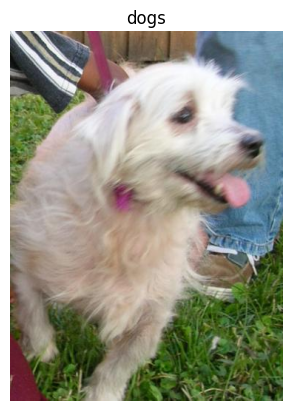

In [89]:
#View random image from the train dataset
img = view_random_image(target_dir = "/content/dataset_cats_and_dogs/train/",
                        target_class = "dogs")

['1.jpg']
Image shape : (281, 300, 3)


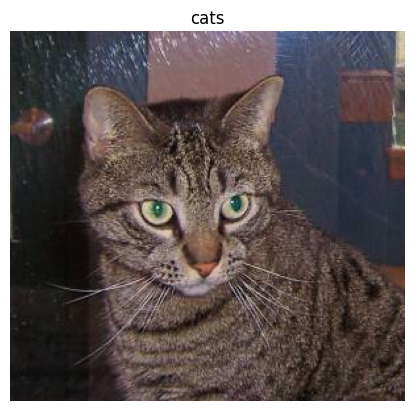

In [90]:
#View random image from the train dataset
img = view_random_image(target_dir = "/content/dataset_cats_and_dogs/train/",
                        target_class = "cats")

In [91]:
train_dir = "/content/dataset_cats_and_dogs/train/"
test_dir = "/content/dataset_cats_and_dogs/test/"

In [92]:
# Create ImageDataGenerator training instance with data augmentation
train_datagen_augmented = ImageDataGenerator(rescale = 1./255.,
                                             rotation_range = 0.2, # How much you want to rotate an image ?
                                             shear_range = 0.2, # How much you want to shear an image ?
                                             zoom_range = 0.2,# How much you want to zoom an image ?
                                             width_shift_range = 0.2, # How much you want to move an image in x-axis ?
                                             height_shift_range = 0.2, # How much you want to move an image in y-axis ?
                                             horizontal_flip = True # Do you want to flip the image

)

# Create ImageDataGenerator training instance without data augmentation
train_datagen = ImageDataGenerator(rescale = 1./255.)

# Create ImageDataGenerator without data augmentation for the test dataset
test_datagen = ImageDataGenerator(rescale = 1./255.)

In [93]:
# Import Data and Augment it from training directory
print("Augmented training data")
train_data_augmented = train_datagen_augmented.flow_from_directory(train_dir,
                                                                   target_size = (224,224),
                                                                   class_mode = "binary",
                                                                   batch_size = 5,
                                                                   shuffle = False) # For demonstration purposes only

print("Non Augmented training data")
train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size = (224,224),
                                               class_mode = "binary",
                                               batch_size = 5,
                                               shuffle = False)

print("Non augmented test data :")
test_data = test_datagen.flow_from_directory(test_dir,
                                               target_size = (224,224),
                                               class_mode = "binary",
                                               batch_size = 5,
                                               shuffle = False)

Augmented training data
Found 30 images belonging to 2 classes.
Non Augmented training data
Found 30 images belonging to 2 classes.
Non augmented test data :
Found 10 images belonging to 2 classes.


In [94]:
# Get sample data batches
images,labels = next(train_data)
augmented_images,augmented_labels = next(train_data_augmented)
import random
random_no = random.randint(0,14)
print(f"Show image number : {random_no}")
plt.imshow(images[random_no])
plt.axis(False)
plt.figure()
plt.imshow(augmented_images[random_no])
plt.axis(False);

Show image number : 9


IndexError: index 9 is out of bounds for axis 0 with size 5

In [ ]:
# Create a model (same as model_4)
model_1 = Sequential([
    Conv2D(10,3,activation = "relu",strides = 1,padding = "valid"),
    Conv2D(10,3,activation = "relu"),
    MaxPool2D(),
    Conv2D(10,3,activation = "relu"),
    Conv2D(10,3,activation = "relu"),
    MaxPool2D(),
    Conv2D(10,3,activation = "relu"),
    Conv2D(10,3,activation = "relu"),
    MaxPool2D(),
    Flatten(),
    tf.keras.layers.Dense(1,activation = "sigmoid")
])

# Compile it

model_1.compile(
     loss = tf.keras.losses.BinaryCrossentropy(),
     optimizer = tf.keras.optimizers.Adam(),
     metrics = ["accuracy"]
 )

# Fit it

history_1 = model_1.fit(train_data_augmented,epochs =5,steps_per_epoch = len(train_data_augmented),validation_data = test_data,validation_steps = len(test_data))

In [ ]:
# Setup EarlyStopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", # monitor validation accuracy
                                                  patience=10) # if val loss decreases for 3 epochs in a row, stop

# Fit the model with the EarlyStopping callback
history_1_early_stop = model_1.fit(train_data_augmented,
                                   epochs=100, # Set a large number of epochs, EarlyStopping will stop it early
                                   steps_per_epoch=len(train_data_augmented),
                                   validation_data=test_data,
                                   validation_steps=len(test_data),
                                   callbacks=[early_stopping])